# **Detection of Malaria cells using Convolution Neural Network**

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline

In [3]:
my_data_dir = '../input/files1/Malaria Cells'

In [4]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(my_data_dir) 

['testing_set', 'single_prediction', 'training_set']

In [5]:
test_path = my_data_dir+'/testing_set'
train_path = my_data_dir+'/training_set'

In [6]:
os.listdir(test_path)

['Uninfected', 'Parasitized']

In [7]:
os.listdir(train_path)

['Uninfected', 'Parasitized']

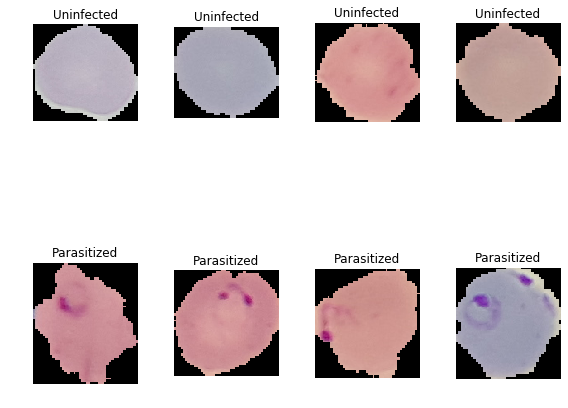

In [8]:
# Define the directories to iterate over
directories = ['Uninfected', 'Parasitized']
# Plot the first four images from both directories
plt.figure(figsize=(8, 8))

for i, directory in enumerate(directories):
    # Path to the current directory
    dir_path = os.path.join(train_path, directory)
    
    # List of image files in the directory
    files = os.listdir(dir_path)[:4]  # Select first four images
    
    # Plot the images
    for j, filename in enumerate(files):
        image_path = os.path.join(dir_path, filename)
        image = imread(image_path)
        
        # Calculate the position of the subplot
        position = i*4 + j + 1
        
        # Plot the image
        plt.subplot(2, 4, position)
        plt.imshow(image)
        plt.title(directory)
        plt.axis('off')
plt.tight_layout()
plt.show()

**Let's check how many images there are.**

In [9]:
len(os.listdir(train_path+'/Parasitized'))

13780

In [10]:
len(os.listdir(train_path+'/Uninfected'))

13780

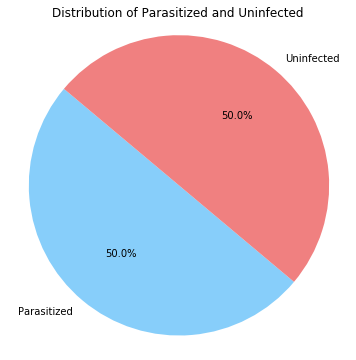

In [39]:
# Get the number of images in each class
num_parasitized = len(os.listdir(train_path+'/Parasitized'))
num_uninfected = len(os.listdir(train_path+'/Uninfected'))

# Create a pie chart
plt.figure(figsize=(6, 6))
labels = ['Parasitized', 'Uninfected']
sizes = [num_parasitized, num_uninfected]
colors = ['lightskyblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Parasitized and Uninfected')
plt.show()

**Let's find out the average dimensions of these images.**

In [11]:
unifected_cell_path = train_path+'/Parasitized/'+os.listdir(train_path+'//Parasitized')[0]
unifected_cell = imread(unifected_cell_path)
unifected_cell.shape

(151, 130, 3)

In [12]:
Parasitized_cell_path = train_path+'/Parasitized/'+os.listdir(train_path+'//Parasitized')[2]
Parasitized_cell = imread(Parasitized_cell_path)
Parasitized_cell.shape

(130, 124, 3)

In [13]:
image_shape = (130,130,3)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [16]:
image_gen.flow_from_directory(train_path)

Found 27558 images belonging to 2 classes.


In [17]:
image_gen.flow_from_directory(test_path)

Found 15832 images belonging to 2 classes.


# Creating the Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
import warnings
warnings.filterwarnings("ignore")

In [30]:
# Initialising the CNN
classifier = Sequential()

#1 - Convolution
classifier.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#2 - Pooling
# Hidden Layer 1
classifier.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a second convolution layer
# relu turns negative values in images to 0
classifier.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#3 - Flattening
# converts the matrix in a singe array
classifier.add(Flatten())


classifier.add(Dense(128))
classifier.add(Activation('relu'))


# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
classifier.add(Dropout(0.5))

#4 - Full Connection
# 128 is the final layer of outputs & from that 1 will be considered.
# Last layer, remember its binary so we use sigmoid
classifier.add(Dense(1))
classifier.add(Activation('sigmoid'))

classifier.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [31]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)            

## Early Stopping

In [32]:
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

## Training the Model

In [34]:
batch_size = 32

In [35]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 27558 images belonging to 2 classes.


In [36]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 15832 images belonging to 2 classes.


In [37]:
train_image_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [38]:
results = classifier.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                             callbacks=[early_stop])

Train for 862 steps, validate for 495 steps
Epoch 1/20
862/862 [==============================] - 299s 347ms/step - loss: 0.3076 - accuracy: 0.8706 - val_loss: 0.1892 - val_accuracy: 0.9367
Epoch 2/20
862/862 [==============================] - 247s 287ms/step - loss: 0.1870 - accuracy: 0.9408 - val_loss: 0.1676 - val_accuracy: 0.9446
Epoch 3/20
862/862 [==============================] - 254s 294ms/step - loss: 0.1687 - accuracy: 0.9467 - val_loss: 0.1750 - val_accuracy: 0.9427
Epoch 4/20
862/862 [==============================] - 244s 284ms/step - loss: 0.1625 - accuracy: 0.9484 - val_loss: 0.1494 - val_accuracy: 0.9476
Epoch 5/20
862/862 [==============================] - 247s 287ms/step - loss: 0.1588 - accuracy: 0.9493 - val_loss: 0.1487 - val_accuracy: 0.9464
Epoch 6/20
862/862 [==============================] - 246s 286ms/step - loss: 0.1511 - accuracy: 0.9530 - val_loss: 0.1465 - val_accuracy: 0.9516
Epoch 7/20
862/862 [==============================] - 244s 283ms/step - loss: 0.

> I used 0.5 or 50% dropping of neurons while training to avoid overfitting problem (dropout)

In [40]:
from tensorflow.keras.models import load_model
classifier.save('malaria_detector.h5')

# Evaluating the Model

In [43]:
losses = pd.DataFrame(classifier.history.history)

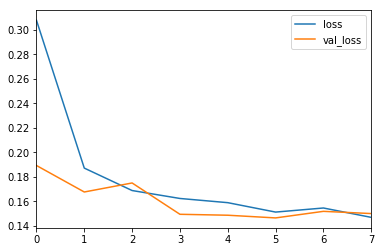

In [44]:
losses[['loss','val_loss']].plot()

In [45]:
acc = pd.DataFrame(classifier.history.history)

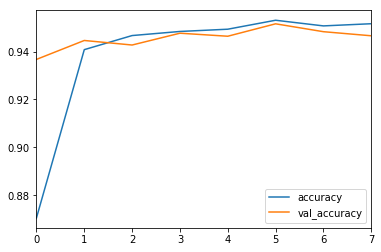

In [46]:
acc[['accuracy','val_accuracy']].plot()

In [47]:
classifier.metrics_names

['loss', 'accuracy']

In [49]:
classifier.evaluate_generator(test_image_gen)

[0.1496786010315209, 0.9472587]

In [50]:
from tensorflow.keras.preprocessing import image

In [51]:
pred_probabilities = classifier.predict_generator(test_image_gen)

In [52]:
pred_probabilities

array([[2.2673905e-03],
       [4.2724609e-04],
       [8.1919730e-03],
       ...,
       [9.7745633e-01],
       [9.8914164e-01],
       [9.8502737e-01]], dtype=float32)

In [53]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [56]:
predictions = pred_probabilities > 0.5

In [57]:
# Numpy can treat this as True/False for us
predictions

array([[False],
       [False],
       [False],
       ...,
       [ True],
       [ True],
       [ True]])

In [58]:
from sklearn.metrics import classification_report,confusion_matrix

In [59]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      7952
           1       0.93      0.97      0.95      7880

    accuracy                           0.95     15832
   macro avg       0.95      0.95      0.95     15832
weighted avg       0.95      0.95      0.95     15832



In [60]:
confusion_matrix(test_image_gen.classes,predictions)

array([[7331,  621],
       [ 214, 7666]])